In [1]:
%matplotlib inline

Ce notebook Jupyter s'intéresse à la résolution numérique de l'équation de la chaleur. Il utilise des cellules de codes interactives que vous pouvez modifier ou utiliser pour générer des données, dessins, animations comme expliqué dans la suite.

On aura besoin des librairies suivantes pour effectuer du calcul formel, numérique et tracer des graphes:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()

from matplotlib import animation, rc
from IPython.display import HTML, Image, set_matplotlib_formats
set_matplotlib_formats('png','pdf')

rc('animation', html='html5')

# Introduction : le problème de la chaleur

## Aspect qualitatif

L'équation de la chaleur permet de modéliser l'évolution de la température dans un milieu en fonction du temps et de l'endroit. Historiquement, elle a été établie par Jean-Baptiste Joseph FOURIER dans son ouvrage « *Théorie analytique de la Chaleur* » (1822). Comme le titre l'indique, il arriva à ce modèle en regardant les échanges d'énergie thermique, ou *chaleur*, entre le milieu considéré et l'extérieur, ainsi que les flux de chaleur au sein du milieu.

Concrètement, les conditions initiales correspondent, comme leur nom l'indique, à la distribution initiale de température dans le milieu, et les conditions aux limites, comme leur nom l'indique encore une fois, à ce qu'il se passe au bord du milieu. Ici, on a choisi des conditions de Neumann, qui expriment la quantité d'échange de chaleur avec l'extérieur. 

On aurait pu également imposer une température au bord du milieu, ce qui serait des conditions aux limites de Dirichlet.

## Aspect mathématique

L'*équation de la chaleur* est la donnée de l'équation aux dérivées partielles suivante:
$$
\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2}
$$

Dans les premiers exemples de ce notebook, on s'intéressera à des problèmes de la forme :
$$
\begin{aligned}
\frac{\partial u}{\partial t} &= D\frac{\partial^2 u}{\partial x^2} \\
u(x,0) &= \alpha + \beta\exp\left(-\frac{(x-a)^2}{\sigma^2}\right) \quad\text{(Conditions initiales)} \\
\frac{\partial u}{\partial x}(0,t) &= \frac{\partial u}{\partial x}u(L,t) = 0\quad\text{(Conditions aux limites de Neumann)}
\end{aligned}
$$
sur un domaine $\Omega\times I = [0,L]\times[0,T]$, avec $0 < a < L$, $\alpha$ et $\beta$ des températures.

# Discrétisation, méthode de Crank-Nicolson

Ce qui suit détaille le procédé de résolution *numérique* (c'est-à-dire qu'on ne cherchera pas une expression de $u(x,t)$, qui peut s'avérer très difficile à obtenir, mais qu'on demandera à un ordinateur d'en calculer une solution approchée en générant à chaque instant une grille de points correspondant à la température aux différents endroits du milieu).

Il n'est absolument pas nécessaire de tout comprendre pour utiliser les fonctions de simulation introduites à la fin de cette section.

## Théorie

Pour cela, on va discrétiser $\Omega\times I$ sous la forme $(x_j,t_n)=(j\Delta x,n\Delta t)_{j,n}$, $0\le j< J$ et $0\le n< N$.

On v s'y prendre en définissant une classe `Domain`, dont les attributs seront les paramètres de la discrétisation: tailles des échantillons, bornes des intervalles, intervalles discrétisés.

Elle ne sera pas utilisée directement ; on va lui subordonner une autre classe `Simulation` (voir plus bas) qui elle servira à effectuer nos simulations.

In [3]:
class Domain():
    """
    Définit le domaine spatio-temporel du problème
    """
    def __init__(self, L, T, J = 512, N = 512):
        self.T = T # temps de la simulation numérique
        self.N = N # Taille des échantillons temporels
        self.times = np.linspace(0,T,N)
        self.dt = T/N
        
        self.L = L # intervalle où simuler
        self.J = J # Taille des échantillons spatiaux
        self.Xs = np.linspace(0,L,J)
        self.dx = 1/J

On pose, pour tout $(j,n)\in [\![0,J-1]\!]\times[\![0,N-1]\!]$, $u_j^n := u(j\Delta x,n\Delta t)$. Alors, en discrétisant les dérivées,
$$
\frac{\partial u}{\partial t} \approx \frac{u_j^{n+1}-u_j^n}{\Delta t}\quad \text{et}\quad \frac{\partial^2u}{\partial x^2}\approx \frac{u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1} + u_{j+1}^n - 2u_j^n + u_{j-1}^n}{2(\Delta x)^2}.
$$

On pose $r:=\frac{D\Delta t}{(\Delta x)^2}$ ; alors on est amené au système d'équations
$$
-ru_{j+1}^{n+1}+(1+2r)u_j^{n+1} - ru_{j-1}^{n+1} = (1-2r)u_j^n + r\left(u_{j+1}^n+u_{j-1}^n\right)\quad \forall (j,n)\in[\![0,J-1]\!]\times[\![0,N-1]\!].
$$

Le problème ici c'est que $u_{-1}^n$ et $u_J^n$ ne sont pas définis. Avec les conditions aux limites
$$
\partial_xu(0,t) = \partial_xu(1,t) = 0
$$
on a
$$
u_{-1}^n = u_0^n \quad\text{et}\quad u_{J}^n = u_{J-1}^n\quad\forall n
$$

ce qui conduit à
$$
\begin{aligned}
-ru_1^{n+1}+ (1+r)u_0^{n+1} &= (1-r)u_0^n + ru_1^n \\
(1+r)u_{J-1}^{n+1}-ru_{J-2}^{n+1} &= (1-r)u_{J-1}^n + ru_{J-2}^n
\end{aligned}
$$

On pose $$ \mathbf U^n = \begin{bmatrix} u_0^{n} \\ \vdots \\ u_{J-1}^n \end{bmatrix} $$
l'état du système à $t_n$ et les matrices
$$\mathbf A 
= \begin{bmatrix}
1+r   & -r  &        &         &       \\
-r & 1+2r   & -r      &        &  \\
   & \ddots & \ddots & \ddots &  \\
   &        & -r      & 1+2r   & -r \\
   &        &        & -r      &  1+r      
\end{bmatrix}
$$
et
$$\mathbf B 
= \begin{bmatrix}
1-r   & r  &        &         &       \\
r & 1-2r   & r      &        &  \\
   & \ddots & \ddots & \ddots &  \\
   &        & r      & 1-2r   & r \\
   &        &        & r      &  1-r      
\end{bmatrix}.
$$


On a donc la relation de passage d'un état au suivant :
$$
\mathbf A\mathbf U^{n+1} = \mathbf B\mathbf U^n,
$$
mais $\mathbf A$ étant inversible,
$$
\mathbf U^{n+1} = \mathbf A^{-1}\mathbf B\mathbf U^n
$$

## Implémentation

### Matrices $\mathbf A$ et $\mathbf B$

La fonction `process_matrix` définit les matrices $\mathbf A$ et $\mathbf B$.

In [4]:
def process_matrix(Omega, diffus):
    J = Omega.J
    dt = Omega.dt
    dx = Omega.dx
    
    r = diffus*dt/(dx*dx)
    A = np.zeros((J,J))
    B = np.zeros((J,J))
    for j in range(0,J):
        if j == 0 or j== J-1:
            A[j][j] = 1 + r
            B[j][j] = 1 - r
        else:
            A[j][j] = 1 + 2* r
            B[j][j] = 1 - 2*r
        if j > 0:
            A[j][j-1] = -r
            B[j][j-1] = r
        if j < J-1:
            A[j][j+1] = -r
            B[j][j+1] = r
    return A,B

### Classe `Simulation`

Nous allons implémenter l'algorithme de Crank-Nicolson via, encore une fois, de la programmation orientée objet, en définissant une classe `Simulation`, dérivée de la classe `Domain`, qui aura pour attributs les autres paramètres de simulation telles que les conditions initiales, et qui disposera de méthodes pour appliquer l'algorithme pour générer une liste de points de la solution approchée, faire les graphes, des animations.

In [5]:
class Simulation(Domain):
    
    def __init__(self, L, T, diffus):
        Domain.__init__(self, L,T)
    
        A,B = process_matrix(self, diffus)
        self.mat = np.matmul(np.linalg.inv(A),B) # Matrice A^{-1}B
    
    def simulate(self, U0):
        C = self.mat
        sol = [U0]
        for t in self.times:
            sol.append(np.matmul(sol[-1], C))
        
        self.data = sol
        self.U0 = U0
    
    def setup_plot(self):
        fig, ax = plt.subplots(1,1)
        ax.grid(True)
        ax.set_xlabel(r"Position $x$ ($m$)")
        ax.set_ylabel(r"Température $u(x,t)$ ($°C$)")

        ax.set_xlim((0,L))
        ymin, ymax = self.U0.min(), self.U0.max()
        ax.set_ylim((ymin,ymax))
        
        return fig, ax
    
    def animate(self):

        Xs = self.Xs
        times = self.times
        sol = self.data
        N = self.N
        T = self.T
        L = self.L
        
        fig, ax = self.setup_plot()
        
        line, = ax.plot([], [], lw = 2)
        time_text = ax.text(0.4,.91, '',transform=ax.transAxes)
        
        time_window = T
        fps = 30
        interval = 1000/fps
        frames = N
        
        def init():
            line.set_data([],[])
            time_text.set_text(r'$t=0$ $\mathrm{s}$')
            return line,

        def animate(i):
            ti = time_window*i/frames
            line.set_data(Xs, sol[i])
            time_text.set_text(r'$t={:.2f}$'.format(ti)+r' $\mathrm{s}$')
            return line,
        
        fig.tight_layout()
        
        self.anim = animation.FuncAnimation(fig, animate, 
                    init_func=init, frames=frames, 
                    interval=interval, blit=True)
    
    def graph(self):
        sol = self.data
        Xs = self.Xs
        
        fig, ax = self.setup_plot()
        
        for i in [0,10,50,100,250]:
            ti = self.T*i/self.N
            ax.plot(Xs,sol[i],label=r'$t={}$'.format(ti)+r' $\mathrm{s}$')
        ax.legend()
        fig.tight_layout()

## Utilisation

Pour générer une instance de simulation, c'est-à-dire une objet de type `Simulation`, il suffit d'utiliser le constructeur `Simulation(L, T, diffus)`, où `L` est la longueur $L$ du domaine spatial, `T` la durée, et `diffus` la valeur du coefficient de diffusion.

Le constructeur prend comme arguments optionnels (`kwargs` pour *keyword arguments*) `N` et `J`, les tailles respectives des échantillons des intervalles de temps et d'espace à prendre. Par défaut ils valent respectivement 512 et 256.

Pour effectuer la simulation, il faut générer une condition initiale, un tableau de taille`J`. L'intervalle échantillonné, pour par exemple générer la condition initiale via une fonction numérique, est dans l'attribut `Xs`. 

Pour tracer le graphe, utiliser la méthode `graph` ; pour une animation, la méthode `animate`.

# Exemples

Fixons une valeur du coefficient de diffusion $D$:

In [6]:
diffus = 22.9e-5

La condition initiale $u(x,0)$ se discrétise en
$$
\mathbf U^0 = \left(\alpha + \beta\exp\left(-\frac{(x_j-x_0)^2}{\sigma^2}\right) \right)_{j\in[\![0,N-1]\!]}
$$

On définit une fonction gaussienne:

In [7]:
def distrib(x, x0, sigma):
    return np.exp(-25*(x-x0)**2/sigma**2)

On commence par une distribution centrée, $x_0=\frac{L}{2}$, avec 
$$
u(x,0) = 25 + 10\exp\left(-\frac{(x-L/2)^2}{\sigma^2}\right)
$$

In [8]:
L = 0.25
T = 270
sigma = 0.3
x0 = L/2
sim = Simulation(L, T, diffus)
U0 = 25+ 10*distrib(sim.Xs, x0, sigma)

sim.simulate(U0)

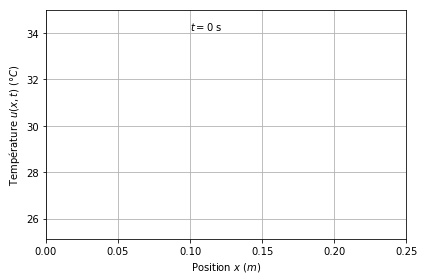

In [9]:
sim.animate()

In [10]:
sim.anim

Une autre simulation, avec $x_0=0$:

In [11]:
sigma = 0.1
x0 = 0.

sim = Simulation(L,180,diffus)
U0 = 10*distrib(sim.Xs, x0, sigma) + 25
sim.simulate(U0)

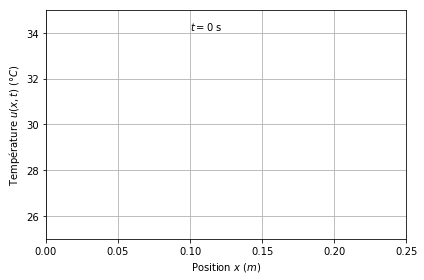

In [12]:
sim.animate()

In [13]:
sim.anim

Encore une autre, avec une « cuve » de température
$$
u(x,0) = 25 + 30\left(\exp\left(-\frac{x^2}{\sigma^2}\right)+\exp\left(-\frac{(x-L)^2}{\sigma^2}\right)\right)
$$

In [14]:
sigma = 0.1
x0 = 0.
x1 = L = 0.25
T = 270

sim = Simulation(L,T,diffus)
U0 = 25+30*(distrib(sim.Xs, x0, sigma) + distrib(sim.Xs, x1, sigma))

sim.simulate(U0)

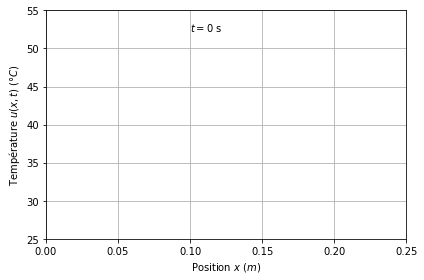

In [15]:
sim.animate()

In [16]:
sim.anim

On va tester une « cuve » et une montagne
$$
u(x,0) = 25 + 10\exp\left(-\frac{x^2}{\sigma^2}\right) - 5\exp\left(-\frac{(x-mL)^2}{\sigma^2}\right)
$$
avec $0< m< 1$.

In [17]:
L = 0.5
T = 270

m = 11/12
x0, sigma0 = 0, 0.1
x1, sigma1 = m*L, 0.2

sim = Simulation(L,T,diffus)

U0 = 20 + 50*distrib(sim.Xs,x0,sigma0) - 30*distrib(sim.Xs,x1,sigma1)

sim.simulate(U0)

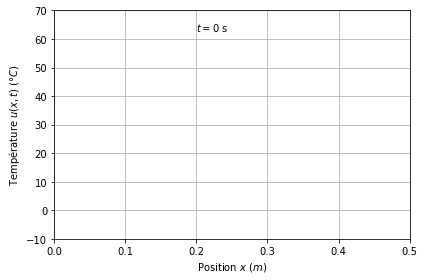

In [18]:
sim.animate()

In [19]:
sim.anim

On peut même tester avec d'autres conditions initiales.